# import dependencies

In [70]:
# Generals
from sklearn.model_selection import train_test_split
from IPython.display  import clear_output 
from typing import Any, Literal
from numpy import floating
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Gym (Environmet)
import gymnasium as gym
from gymnasium import spaces


# Modeling (PyTorch)
import torch.nn.functional as F
import torch
Tensor = torch.Tensor
import torch.nn as nn
from torch.optim import Adam, RMSprop
from torch.distributions import Categorical


In [71]:
try: 
	import backtrader as bt
	# import
	print('`backtrader` import Succesfully')
except ModuleNotFoundError:
	pass
	%pip install backtrader 
	clear_output ()
	import backtrader as bt
	print('Module`backtrader` NotFound Error. So installed')


`backtrader` import Succesfully


In [72]:
try: 
	import openpyxl
	print('`openpyxl` import Succesfully')
except ModuleNotFoundError:
	pass
	%pip install openpyxl 
	clear_output ()
	import openpyxl
	print('Module `openpyxl` NotFound Error. So installed')

`openpyxl` import Succesfully


In [73]:
%matplotlib inline

# data Import

In [74]:
kaggle = False

if kaggle:
	path_m5_xau : str = r"/kaggle/input/price-values/price-values/XAUUSDM5.csv"
	path_m15_xau: str = r"/kaggle/input/price-values/price-values/XAUUSDM15.csv"
	path_daily_xau: str = r"/kaggle/input/price-values/price-values/XAUUSDDaily.csv"

	path_m5_eur: str = r"/kaggle/input/price-values/price-values/EURUSDM5.csv"
	path_m15_eur: str = r"/kaggle/input/price-values/price-values/EURUSDM15.csv"
	path_daily_eur: str = r"/kaggle/input/price-values/price-values/EURUSDDaily.csv"

else:
	path_m5_xau : str = r"price-values/XAUUSDM5.csv"
	path_m15_xau: str = r"price-values/XAUUSDM15.csv"
	path_daily_xau: str = r"price-values/XAUUSDDaily.csv"

	path_m5_eur: str = r"price-values/EURUSDM5.csv"
	path_m15_eur: str = r"price-values/EURUSDM15.csv"
	path_daily_eur: str = r"price-values/EURUSDDaily.csv"


In [75]:
Round = 4
rsi_len = 14
movAvgLen = 5
ma_1 = 10
ma_2 = 20

## small DataFrame

In [76]:
df_small = pd.read_csv(path_m5_eur , 
				   encoding = 'utf-16', 
				   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df_small['Date'] = pd.to_datetime(df_small['Date'])
df_small.set_index('Date', drop=True, inplace = True)
df_small.drop('0', axis=1,  inplace = True)

print(df_small.shape)
df_small.head()

(100000, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122


## Big DataFrame

In [77]:
df_big = pd.read_csv(path_daily_eur , 
				   encoding = 'utf-16', 
				   names =  ['Date', 'Open D', 'High D', 'Low D', 'Close D', 'Volume D', '0'] )

df_big['Date'] = pd.to_datetime(df_big['Date'])
df_big.set_index('Date', drop=True, inplace = True)
df_big.drop('0', axis=1,  inplace = True)

print(df_big.shape)
df_big.head()

(1131, 5)


,Open D,High D,Low D,Close D,Volume D
Date,,,,,
2021-03-29,1.17886,1.17937,1.17608,1.17642,59703
2021-03-30,1.17640,1.17736,1.17114,1.17169,56334
2021-03-31,1.17170,1.17598,1.17041,1.17298,60218
2021-04-01,1.17298,1.17799,1.17124,1.17759,54081
2021-04-02,1.17760,1.17864,1.17488,1.17608,25975


## Total DataFrame

In [78]:
df_total = pd.concat([df_small, df_big], axis=1)
df_total.fillna(0, inplace = True)
print(df_total.shape)
df_total.tail()

(100781, 10)


,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D
Date,,,,,,,,,,
2025-07-28 01:50:00,1.17529,1.17547,1.17528,1.17547,63.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-28 01:55:00,1.17547,1.17569,1.17541,1.17545,96.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-28 02:00:00,1.17546,1.17575,1.17540,1.17565,98.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-29 00:00:00,0.00000,0.00000,0.00000,0.00000,0.0,1.15854,1.15987,1.15185,1.15442,56173.0
2025-07-30 00:00:00,0.00000,0.00000,0.00000,0.00000,0.0,1.15421,1.15497,1.15420,1.15487,809.0


# Needed Functions

In [79]:

def calculate_RSI(data: Series , time_window : int = 14) -> Series:
		delta: Series[type[float]] = data.diff() # type: ignore

		up, down = delta.copy(), delta.copy()
		up[up < 0] = 0 # type: ignore
		down[down > 0] = 0 # type: ignore

		roll_up: Series[float] = up.rolling(time_window).mean()
		roll_down: Series[float] = down.abs().rolling(time_window).mean()

		RS: Series[float] = roll_up / roll_down
		RSI: Series[float] = 100.0 - (100.0 / (1.0 + RS))

		return RSI.round(Round)



def macd(data, fast, slow):
	if isinstance(data, np.ndarray):
		ma1 =  np.convolve(data, np.ones(fast)/fast, mode='valid')
		ma2 =  np.convolve(data, np.ones(slow)/slow, mode='valid')
		return ma2 - ma1
	if isinstance(data, pd.Series):
		ma1 =  data.rolling(fast, min_periods=1).mean()
		ma2 =  data.rolling(slow, min_periods=1).mean()
		return ma2 - ma1



def clc_mean(series : Series , window: int) :
		rolling_mean = series.rolling(window=window).mean().round(Round)
		return  rolling_mean

def moving_avg_std(series : Series , window : int)  -> Series:
	"""Calculate the moving average and standard deviation of a pandas series, and then divide the two"""
	rolling_mean = series.rolling(window=window).mean().round(Round)
	rolling_std = series.rolling(window=window).std().round(Round)
	return rolling_mean - rolling_std



In [80]:
def creat_data(df: pd.DataFrame):
	df['MovAvg'] = df['Close'].rolling(movAvgLen).mean()

	df['diff']  =  (df['Close'] - df['MovAvg']).round(Round) 
	df['cadle-type']  = (df['Close'] - df['Open']).round(Round)
	df['change']  =  df['Open'] - df['MovAvg'] 
	df['macd'] = macd(df['Close'], movAvgLen, movAvgLen*2 )
	df['percent']  =  (df['Close'] - df['Open']) / df['Close']  * 100

	df['rsi']  = calculate_RSI( df['Open'] , rsi_len ) / 100

	df['Pivot'] = (df['High'] + df['Low'] + df['Close']) / 3
	# Optional: First support and resistance
	df['R1'] = (2 * df['Pivot']) - df['Low']
	df['S1'] = (2 * df['Pivot']) - df['High']

	try:
		df['MovAvg D'] = df['Close D'].rolling(movAvgLen).mean()
		df['Pivot D'] = (df['High D'] + df['Low D'] + df['Close D']) / 3
		df['rsi D']  = calculate_RSI( df['Open D'] , rsi_len ) / 100
		df['R1 D'] = (2 * df['Pivot D']) - df['Low D']
		df['S1 D'] = (2 * df['Pivot D']) - df['High D']

	except KeyError as e:
		pass

	# df['buy'] = np.where( (df['Open'] > clc_mean(df['Open'],movAvgLen).shift(1)) & (df['cadle-type'] >= .65), 1 ,0 )

	# df['sell'] = np.where( (df['Open'] < clc_mean(df['Open'],movAvgLen).shift(1)) & (abs(df['cadle-type']) >= .65)  , 1 ,0 )

	# df['hold'] = np.where(df['buy'] == df['sell'], 1, 0)


	df = df.dropna(axis=0)

	return df

In [81]:
df_total.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Open D', 'High D', 'Low D',
       'Close D', 'Volume D'],
      dtype='object')

# create Data

In [82]:
df_total = df_total[
	['Open', 'High', 'Low', 'Close', 'Volume', 
	 'Open D', 'High D', 'Low D', 'Close D', 'Volume D']
	 							]
df = creat_data(df_total)
df['Volume'] = df['Volume'].astype(np.float64)
df.head(10)

,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D,...,percent,rsi,Pivot,R1,S1,MovAvg D,Pivot D,rsi D,R1 D,S1 D
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86.0,0.0,0.0,0.0,0.0,0.0,...,0.007382,1.000000,1.083750,1.083820,1.083690,0.869016,0.0,0.015532,0.0,0.0
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79.0,0.0,0.0,0.0,0.0,0.0,...,0.002768,1.000000,1.083830,1.083900,1.083720,0.651726,0.0,0.015426,0.0,0.0
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132.0,0.0,0.0,0.0,0.0,0.0,...,0.000923,1.000000,1.083827,1.083893,1.083733,0.433316,0.0,0.011765,0.0,0.0
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151.0,0.0,0.0,0.0,0.0,0.0,...,-0.015688,1.000000,1.083683,1.083787,1.083527,0.216124,0.0,0.007344,0.0,0.0
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122.0,0.0,0.0,0.0,0.0,0.0,...,0.027677,0.999843,1.083840,1.084050,1.083720,0.000000,0.0,0.007350,0.0,0.0
2024-03-22 05:40:00,1.08394,1.08396,1.08385,1.08390,77.0,0.0,0.0,0.0,0.0,0.0,...,-0.003690,0.999843,1.083903,1.083957,1.083847,0.000000,0.0,0.007359,0.0,0.0
2024-03-22 05:45:00,1.08390,1.08402,1.08387,1.08395,102.0,0.0,0.0,0.0,0.0,0.0,...,0.004613,0.999806,1.083947,1.084023,1.083873,0.000000,0.0,0.007252,0.0,0.0
2024-03-22 05:50:00,1.08395,1.08397,1.08378,1.08378,81.0,0.0,0.0,0.0,0.0,0.0,...,-0.015686,0.999806,1.083843,1.083907,1.083717,0.000000,0.0,0.005332,0.0,0.0
2024-03-22 05:55:00,1.08378,1.08387,1.08376,1.08380,120.0,0.0,0.0,0.0,0.0,0.0,...,0.001845,0.999650,1.083810,1.083860,1.083750,0.000000,0.0,0.005362,0.0,0.0


## Choosing Features

## Final Features

In [83]:
data = df[
				[	'Open', 'High', 'Low' , 'Close', 'Volume',
					# 'macd',
					'Pivot D', 
					#   "R1 D", 'S1 D', 
					# 'MovAvg D'
				]
					]
data.head(10)

,Open,High,Low,Close,Volume,Pivot D
Date,,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86.0,0.0
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79.0,0.0
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132.0,0.0
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151.0,0.0
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122.0,0.0
2024-03-22 05:40:00,1.08394,1.08396,1.08385,1.08390,77.0,0.0
2024-03-22 05:45:00,1.08390,1.08402,1.08387,1.08395,102.0,0.0
2024-03-22 05:50:00,1.08395,1.08397,1.08378,1.08378,81.0,0.0
2024-03-22 05:55:00,1.08378,1.08387,1.08376,1.08380,120.0,0.0


# Create Envirnment

In [84]:
import torch.nn as nn
from torch import Tensor
import torch



class PolicyNetwork(nn.Module):
	def __init__(self, win_size , n_feature):
		"""
		## params :
			### win_size: window size of data. Trained on : 5
			### n_feature: Positins; '0 as Buy', '1 as Sell', '2 as Hold(do nothing)'

		## Structure:
			### layers:
				#### norm_all :
					A layer for normalizing Data.
					pros: 
						- Optimized PArameter Over Trainig Process
				#### i_know :
					A `LSTM` Network, for predict later Values
				#### i_see:
					A `CNN` model to finding 'Hidden features' in values in a window size
				#### i_decide:
					A Fully Connected Network, to  decide on what position should be !
		
		# How to use model:
		after data feed to the network and labels generated. use the following code to figure out what label has be generated
		```
		import torch.nn.functional as F
		from torch.distributions import Categorical
		with torch.no_grad():
			probs  = F.softmax(agent(state), dim=-1) 
			m = Categorical(probs)
			action = m.sample().squeeze(0).item()
		```
		"""
		
		super().__init__()
		# Normalize Data: 
		self.norm_all = nn.LayerNorm(n_feature)
		
		self.i_know = nn.LSTM(input_size=n_feature, 
						hidden_size=n_feature,
						  num_layers= 128,
						  batch_first=True,
						  bidirectional= False
						  )
		

		
		self.i_see = nn.Sequential(
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=7, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU(),
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=5, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU(),
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=3, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU()
			)

		self.i_decide = nn.Sequential(
			nn.Flatten(),
			nn.Linear(win_size * n_feature *2, 1024), 
			nn.Dropout(.5),
			nn.LeakyReLU(),
			nn.Linear(1024, 512), 
			nn.LeakyReLU(),
			nn.Linear(512, 128), 
			# -------------------------------------
			nn.Linear(128, 812), # fc1
			nn.Dropout(.5),
			nn.LeakyReLU(),
			nn.Linear(812, 128), # fc2
			nn.LeakyReLU(),
			nn.Linear(128, 3), # out
	
		)


	def forward(self, X: Tensor) -> Tensor:
		"""
		# input:
		#### X : a Tensor of Values shape '(w, d)'
			w : window size
			d: features of price : 'Open', 'High' ,'Low' ,'Close' ,'Volume' , 'pivot D'(Pivot on daliy chart)  
		# Ouput:
			a torch '(f, 1)' tensor of values decade for labels 			
		"""
		x : Tensor = self.norm_all(X).unsqueeze(0)

		iknow : Tensor
		iknow ,_ = self.i_know(x)

		isee : Tensor = self.i_see(x)
		# print(isee.shape, iknow.shape)
		# whathpend =  F.sigmoid(isee + iknow)
		whathpend =  torch.cat([iknow, isee], dim=1) #isee + iknow.tanh()
		# print(torch.cat([iknow, isee], dim=1).shape)
		# print(torch.cat([iknow, isee], dim=1).flatten().shape)
		out = self.i_decide(whathpend)

		return out



In [85]:
# torch.serialization.add_safe_globals([PolicyNetwork])
import json


with open("config.json", "r") as f:
    config = json.load(f)
    

config

{'win_size': 5, 'n_feature': 6}

In [86]:

policy = PolicyNetwork(**config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [87]:
policy_dict = torch.load(r'saved-trade-model.pt', weights_only=True,map_location=device)
# policy.eval()
print(policy_dict)

OrderedDict({'norm_all.weight': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]), 'norm_all.bias': tensor([-2.6259e-05, -2.3877e-06, -6.3831e-06,  6.7227e-06, -3.4560e-06,
         1.1154e-05]), 'i_know.weight_ih_l0': tensor([[ 0.1065,  0.3550, -0.0213, -0.2167, -0.1513,  0.3467],
        [-0.2886,  0.3666,  0.4020,  0.1748, -0.3398,  0.2028],
        [-0.0344,  0.3717,  0.3346, -0.0419,  0.0439,  0.3240],
        [ 0.0805,  0.2557, -0.2610,  0.0964, -0.2978,  0.0533],
        [-0.0132,  0.2496,  0.1453, -0.3634, -0.0046, -0.2987],
        [ 0.3004,  0.1705,  0.0676, -0.0558,  0.2453,  0.1181],
        [-0.3605,  0.3831, -0.3197, -0.3927,  0.1354,  0.2991],
        [ 0.2900, -0.0977,  0.2381,  0.3832, -0.0614, -0.2668],
        [-0.1297, -0.0724, -0.0719,  0.3865,  0.3808, -0.2569],
        [ 0.3004, -0.0429, -0.1941, -0.3049, -0.0194, -0.3839],
        [-0.1061, -0.1966, -0.0345,  0.2309, -0.0485,  0.3499],
        [-0.0554,  0.4037, -0.1459, -0.0531,  0.0385, -0.2477],
      

In [88]:
policy.load_state_dict(policy_dict)
policy.eval()

PolicyNetwork(
  (norm_all): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (i_know): LSTM(6, 6, num_layers=128, batch_first=True)
  (i_see): Sequential(
    (0): Conv1d(5, 5, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(5, 5, kernel_size=(5,), stride=(1,), padding=same)
    (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=same)
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (i_decide): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=60, out_features=1024, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_fea

## Data for Backtesting

In [89]:
# 1. Define a custom Pandas feed with signal line
class PandasSignalData(bt.feeds.PandasData):
	lines = ('Pivot',)  
	params = (('Pivot', 5),


		   )  # tell backtrader where to find it (column index or name)


## Strategy for Backtesting

In [90]:
class TestStrategy(bt.Strategy):
	params = dict(
		value_type = False,
		tp_percent= .01 ,  #  `tp` % take profit 
		sl_percent= .01 ,  #  `sl` % stop loss 
		tp_value = .005 ,  #  `tp` $ take profit
		sl_value = .005 ,  #  `sl` $ stop loss
		max_hold= None  ,  # maximum candle to hold on a position
		size = .001      # Position Size
	)

	def __init__(self):
		# self.signal = self.datas[0].signal
		self.entry_price = None
		self.bar_executed = None
		self.position_type = None  # 'long' or 'short'
		self.order_dict = dict()
		self.logs_list = []
		self.agent = policy
		self.status = dict(
			zip(range(len(bt.Order.Status)) ,bt.Order.Status) )
	
	def _predict(self, state):
		with torch.no_grad():
			probs  = F.softmax(self.agent(state), dim=-1) # type: ignore
			m = Categorical(probs)
			action = m.sample().squeeze(0).item()
			return action

	# === تغییرات ===
	def _get_state_window(self, window_size=5):
		state = []
		for i in range(-window_size + 1, 1):
			state.append([
				self.data.close[i],
				self.data.open[i],
				self.data.high[i],
				self.data.low[i],
				self.data.volume[i],
				self.data.Pivot [i]
			])
		return torch.tensor(state, dtype=torch.float).to(device) # shape: (1, 5, 5)

	def next(self):
		price_now = self.data.close[0]
		state = self._get_state_window()
		predict = self._predict(state)
		
		if not self.position:
			# Open Long
			if predict == 0:
				self.entry_price = price_now
				self.buy(size=self.p.size)
				self.bar_executed = len(self)
				self.position_type = 'long'

				self.logs_list.append({
					'datetime': self.data.datetime.datetime(0),
					'action': 'BUY',
					'entry_price': price_now,
					'tp_price': price_now * (1 + self.p.tp_percent) if not self.p.value_type else price_now + self.p.tp_value,
					'sl_price': price_now * (1 - self.p.sl_percent) if not self.p.value_type else price_now - self.p.sl_value,
					'size': self.p.size,
					'position_type': 'long',
					'exit_reason': None,
					'exit_price': None,
					'pnl': None,
					'note' : None
				})

			# Open Short
			elif predict == 1:
				self.entry_price = price_now
				self.sell(size=self.p.size)
				self.bar_executed = len(self)
				self.position_type = 'short'

				self.logs_list.append({
					'datetime': self.data.datetime.datetime(0),
					'action': 'SELL',
					'entry_price': price_now,
					'tp_price': price_now * (1 - self.p.tp_percent) if not self.p.value_type else price_now - self.p.tp_value,
					'sl_price': price_now * (1 + self.p.sl_percent) if not self.p.value_type else price_now + self.p.sl_value,
					'size': self.p.size,
					'position_type': 'short',
					'exit_reason': None,
					'exit_price': None,
					'pnl': None,
				})

		# Tp and Sl Organizing
		else:
			# Habdling Long
			if self.position_type == 'long':
				tp_price = self.entry_price * (1 + self.p.tp_percent) if not self.p.value_type else self.entry_price + self.p.tp_value
				sl_price = self.entry_price * (1 - self.p.sl_percent) if not self.p.value_type else self.entry_price - self.p.sl_value

				if price_now >= tp_price:
					self.close()
					pnl = (price_now - self.entry_price) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'TP'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now <= sl_price:
					self.close()
					pnl = (price_now - self.entry_price) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'SL'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# Handling Short
			elif self.position_type == 'short':
				tp_price = self.entry_price * (1 - self.p.tp_percent) if not self.p.value_type else self.entry_price - self.p.tp_value
				sl_price = self.entry_price * (1 + self.p.sl_percent) if not self.p.value_type else self.entry_price + self.p.sl_value

				if price_now <= tp_price:
					self.close()
					pnl = (self.entry_price - price_now) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'TP'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now >= sl_price:
					self.close()
					pnl = (self.entry_price - price_now) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'SL'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# Time Exit
			if self.p.max_hold is not None and self.bar_executed is not None:
				if (len(self) - self.bar_executed) >= self.p.max_hold:
					if self.position_type == 'long':
						pnl = (price_now - self.entry_price) * self.p.size
					elif self.position_type == 'short':
						pnl = (self.entry_price - price_now) * self.p.size
					else:
						pnl = 0

					self.logs_list[-1]['exit_reason'] = 'TIME'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.close()
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

	def log(self, txt, dt=None):
		''' Logging function fot this strategy'''
		dt = dt or self.datas[0].datetime.datetime()
		print('%s | %s' % (dt.isoformat(), txt))

	def notify(self, order):
		if order.status in [order.Submitted, order.Accepted]:
			# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return 

		# Check if an order has been completed
		# Attention: broker could reject order if not enougth cash
		if order.status in [order.Completed, order.Canceled, order.Margin]:
			if order.isbuy():
				self.log(
					'BUY %s | Price: %.4f | Cost: %.4f | Comm %.4f' %
					(self.status[order.status],
						order.executed.price,
					 order.executed.value,
					 order.executed.comm))
			elif order.issell():  # Sell
				self.log('SELL %s | Price: %.4f | Cost: %.4f | Comm %.4f' %
						 (self.status[order.status],
							order.executed.price,
						  order.executed.value,
						  order.executed.comm))
			else:
				self.log("noth")

	def notify_trade(self, trade):
		if trade.isclosed:
			self.log('POSITION CLOSE | GROSS %.4f  | NET %.4f' %
					 (trade.pnl, trade.pnlcomm))
			

	def notify_order(self, order):
		if order.status in [bt.Order.Completed, bt.Order.Canceled, bt.Order.Rejected, bt.Order.Expired]:
			log_entry = {
				'datetime': self.data.datetime.datetime(0),
				'status': order.getstatusname(),
				'action': 'BUY' if order.isbuy() else 'SELL',
				'price_executed': order.executed.price if order.executed.price else None,
				'size': order.executed.size if order.executed.size else None,
				'commission': order.executed.comm if order.executed.comm else None,
				'position_type': self.position_type,
				'entry_price': self.entry_price,
				'tp_price': None,
				'sl_price': None,
				'exit_reason': None,
				'note': None,
			}

			# فقط اگر سفارش اجرا شده (پوزیشن باز یا بسته شده)
			if order.status == bt.Order.Completed:
				if self.position_type == 'long':
					if self.p.value_type:
						log_entry['tp_price'] = self.entry_price + self.p.tp_value
						log_entry['sl_price'] = self.entry_price - self.p.sl_value
						log_entry['note'] = self.status[order.status]
					else:
						log_entry['tp_price'] = self.entry_price * (1 + self.p.tp_percent)
						log_entry['sl_price'] = self.entry_price * (1 - self.p.sl_percent)
						log_entry['note'] = self.status[order.status]


				elif self.position_type == 'short':
					if self.p.value_type:
						log_entry['tp_price'] = self.entry_price - self.p.tp_value
						log_entry['sl_price'] = self.entry_price + self.p.sl_value
						log_entry['note'] = self.status[order.status]

					else:
						log_entry['tp_price'] = self.entry_price * (1 - self.p.tp_percent)
						log_entry['sl_price'] = self.entry_price * (1 + self.p.sl_percent)
						log_entry['note'] = self.status[order.status]


			elif order.status == bt.Order.Canceled:
				log_entry['note'] = 'Canceled by system'
			elif order.status == bt.Order.Rejected:
				log_entry['note'] = 'Rejected by broker (margin?)'
			elif order.status == bt.Order.Expired:
				log_entry['note'] = 'Expired before execution'
			


			self.logs_list.append(log_entry)


	def stop(self):
		df = pd.DataFrame(self.logs_list)
		df.to_csv('tradelog.csv', index=False)


## Run Backtesting

In [91]:
# 4. Feed into backtrader
trade_data = PandasSignalData(dataname=data) # type: ignore



cerebro = bt.Cerebro()
cerebro.adddata(trade_data)
cerebro.addstrategy(TestStrategy)

cerebro.broker.setcommission(
	commission= 0., margin=10_000, mult=100)


cerebro.broker.setcash(100_000)

cerebro.addanalyzer(bt.analyzers.SharpeRatio,
					 _name='sharpe', 
					 timeframe=bt.TimeFrame.Days,  # type: ignore
					#  riskfreerate = 1e-1, 
					#  compression = 5
					 )
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addwriter(bt.writer.WriterFile,out= 'results.csv', csv=True , close_out= True)

cerebro.broker.set_shortcash(True)


results = cerebro.run()
strategy = results[0]


sharpe = strategy .analyzers.sharpe.get_analysis()
drawdown = strategy .analyzers.drawdown.get_analysis()

trades = strategy .analyzers.trades.get_analysis()
returns = strategy .analyzers.returns.get_analysis()




2024-03-22T05:30:00 | SELL Completed | Price: 1.0838 | Cost: 10.0000 | Comm 0.0000
2024-04-12T00:05:00 | BUY Completed | Price: 1.0726 | Cost: 10.0000 | Comm 0.0000
2024-04-12T00:05:00 | POSITION CLOSE | GROSS 0.0011  | NET 0.0011
2024-04-12T00:10:00 | SELL Completed | Price: 1.0727 | Cost: 10.0000 | Comm 0.0000
2024-04-17T00:05:00 | BUY Completed | Price: 1.0615 | Cost: 10.0000 | Comm 0.0000
2024-04-17T00:05:00 | POSITION CLOSE | GROSS 0.0011  | NET 0.0011
2024-04-17T00:15:00 | BUY Completed | Price: 1.0614 | Cost: 10.0000 | Comm 0.0000
2024-04-26T00:05:00 | SELL Completed | Price: 1.0727 | Cost: 10.0000 | Comm 0.0000
2024-04-26T00:05:00 | POSITION CLOSE | GROSS 0.0011  | NET 0.0011
2024-04-26T00:10:00 | SELL Completed | Price: 1.0728 | Cost: 10.0000 | Comm 0.0000
2024-05-16T00:05:00 | BUY Completed | Price: 1.0883 | Cost: 10.0000 | Comm 0.0000
2024-05-16T00:05:00 | POSITION CLOSE | GROSS -0.0016  | NET -0.0016
2024-05-16T00:20:00 | BUY Completed | Price: 1.0879 | Cost: 10.0000 | Comm

## Eval Strategy

## strategy Stats

In [94]:

trade_stats = {
	"Starting Value" :[cerebro.broker.startingcash],
	"Final Value": [cerebro.broker._valuelever],
    'gross' : [cerebro.broker._valuelever - cerebro.broker.startingcash],
	"PnL Tot" : [trades['pnl']['gross']['total']],
	"PnL Avg" : [trades['pnl']['gross']['average']],
	'won' : [trades['won']['total']],
	'lost' : [trades['lost']['total']],

	"Buy Orders": [trades['long']['total']],
	"Sell Orders": [trades['short']['total']],
	"Total Orders": [trades['total']['total']],
	'Buy/T (%)' : [np.round(trades['long']['total'] / (trades['long']['total'] + trades['short']['total']) , 4)*100],
	'Sell/T (%)' : [ np.round(trades['short']['total'] / (trades['long']['total'] + trades['short']['total']) ,4)*100 ], 
	'totral return'  : [returns['rtot']],
	'Avg return' : [returns['ravg']],
	"Sharpe Ratio": [round(sharpe.get('sharperatio', float('nan')), 4)],
	"Max Drawdown (%)": [round(drawdown.max.drawdown, 2)],
	"Net Profit (%)": [round(returns['rtot'] * 100, 2)],
	"Win Rate (%)": [round(trades['won']['total'] / trades['total']['total'] * 100, 10)]
}

trade_stats = pd.DataFrame(trade_stats, index = ['value']).T
trade_stats



,value
Starting Value,1.000000e+05
Final Value,9.999999e+04
gross,-1.163900e-02
PnL Tot,-1.165900e-02
PnL Avg,-2.989487e-04
won,1.700000e+01
lost,2.200000e+01
Buy Orders,1.600000e+01
Sell Orders,2.300000e+01
Total Orders,4.000000e+01


<IPython.core.display.Javascript object>

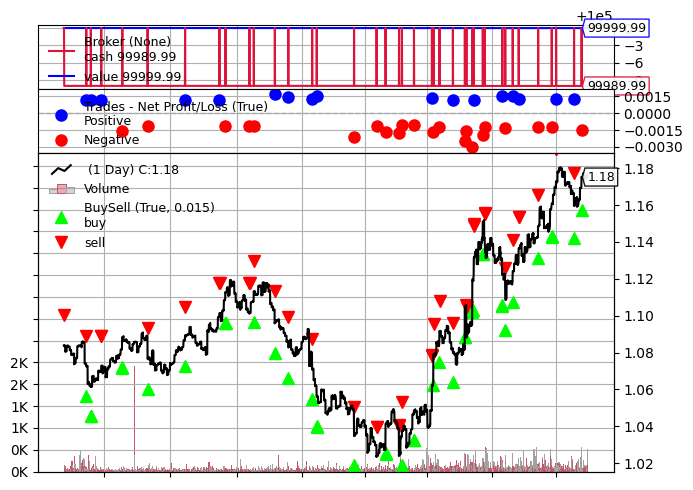

In [95]:

cerebro.plot(
			# width = 100, 
			# height = 50, 
			dpi=500,
			iplot= True,
			)[0][0]  # type: ignore
